In [1]:
import sys

import numpy as np
import xarray as xr
import geopandas as gpd

from odc.geo.gridspec import GridSpec
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox
from odc.geo.types import xy_

import datacube
dc = datacube.Datacube()

from dea_tools.datahandling import load_reproject

sys.path.insert(1, "/home/jovyan/code/supratidal_forests/functions")
from least_cost_path import xr_cost_distance, load_connectivity_mask_aquatic

### setup gridspec

In [2]:
# Expanded Extents 96 km tiling grid
gs_c3_expanded = GridSpec(
    crs="EPSG:3577",
    resolution=30,
    tile_shape=(3200, 3200),
    origin=xy_(-4416000, -6912000),
)

In [3]:
# Visualising whole grid
# Set bounding box
c3_bbox = BoundingBox(
    left=-2400000, bottom=-5088000, right=2784000, top=-864000, crs="EPSG:3577"
)

# Convert grid to geopandas polygon dataset covering full C3 grid extent
grid_gdf = gpd.GeoDataFrame.from_features(
    gs_c3_expanded.geojson(bbox=c3_bbox),
    crs="EPSG:4326", # TODO: Raf, why is this crs different to above c3_bbox? This seems problematic. Please investigate
)
grid_gdf.explore()

In [4]:
# Extract GeoBox for specific tile 
bbox = (45, 58) # x51y54
geobox = gs_c3_expanded[bbox]  
geobox.explore()

### load in layers to make connectivity mask
- DEA mangroves
- JCU saltmarsh
- CEM tidal Flats, Intertidal reefs and Intertidal rocky substratum (2), Mangroves (3), Saltmarsh (4), Intertidal Seagrass (5)

In [5]:
# Buffer input geobox and reduce resolution to ensure that the
# connectivity analysis is less affected by edge effects
buffer = 20000 # this is from load_connectivity_mask function. hardcoded here and will need to change if function value is change in load_connectivity_mask_aquatic
geobox_buffered = GeoBox.from_bbox(
    geobox.buffered(xbuff=buffer, ybuff=buffer).boundingbox,
    resolution=30,
    tight=True,
)

In [41]:
# Load srtm to buffered geobox
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', resampling="bilinear", like=geobox_buffered).squeeze()
srtm = srtm_ds.dem_h

# load in DEA mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', time = ("2020", "2020"), like=geobox_buffered)
# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)

# Load in JCU saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
# saltmarsh = rio_slurp_xarray(geotiff_path, gbox=srtm_buffered.geobox)
# saltmarsh.attrs['crs'] = 'EPSG:3577'
saltmarsh = load_reproject(path=geotiff_path, how=geobox_buffered)

# Load in JCU saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
# saltflat = rio_slurp_xarray(geotiff_path, gbox=srtm_buffered.geobox)
# saltflat.attrs['crs'] = 'EPSG:3577'
saltflat = load_reproject(path=geotiff_path, how=geobox_buffered)

# Load in CEM data
geotiff_path = '/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/CEM_v002/ga_s2ls_coastalecosystems_cyear_3_2021--P1Y_interim_classification_0-0-2.tif'
CEM_data = load_reproject(path=geotiff_path, how=geobox_buffered)
CEM = ~CEM_data.isnull()

In [42]:
# ocean nodata points
srtm_da = srtm == srtm.nodata

# combine masks for LCP, where 1 indicates aquatic features to start calculating LCP from, 0 are areas that will be given a LCP value
aquatic = xr.where((mangrove == True) | (saltmarsh == True) | 
                   (saltflat == True) | (CEM == True) | (srtm_da == True), 1, 0).astype('bool').squeeze('time') # TODO: Raf, investigate issue sometimes here with time dim (i.e. tile 45, 57)
# load_reproject is dask arrays, change to dataarray
aquatic = aquatic.compute()

### run least cost path

In [43]:
# Run connectivity mask analysis
costdist_mask, costdist_da = load_connectivity_mask_aquatic(dc, geobox, starts_da = aquatic) # TODO: Raf, check buffer distance, default is 20km, but we might need more. Look at adjacent tiles across country to find an appropriate distance

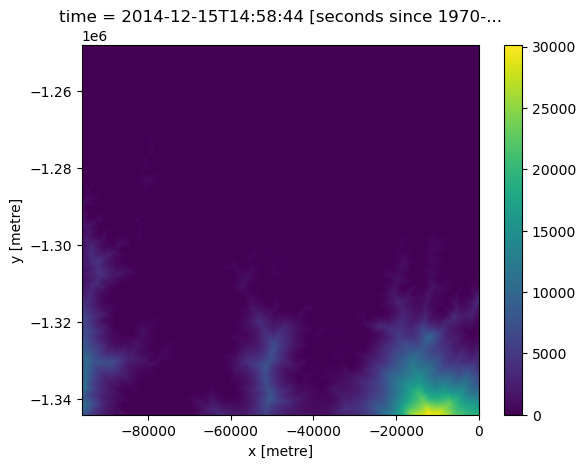

In [44]:
costdist_da.plot()

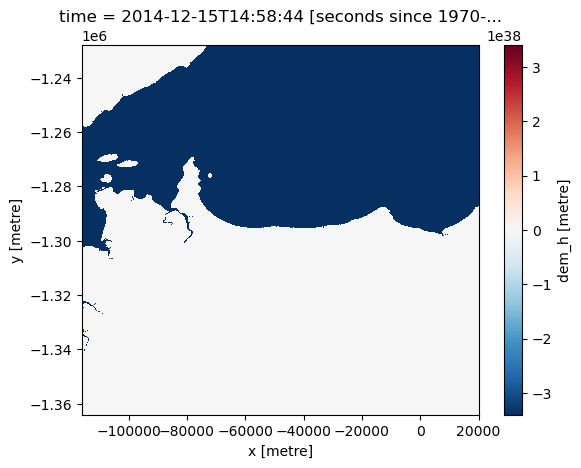

In [45]:
srtm.plot()

In [46]:
# Access nodata value from the DataArray attributes
nodata_value = srtm.attrs.get("nodata", None)

# Replace nodata values with np.nan if nodata_value is defined
if nodata_value is not None:
    srtm_masked = srtm.where(srtm != nodata_value, np.nan)
else:
    print("No nodata value found in attributes.")

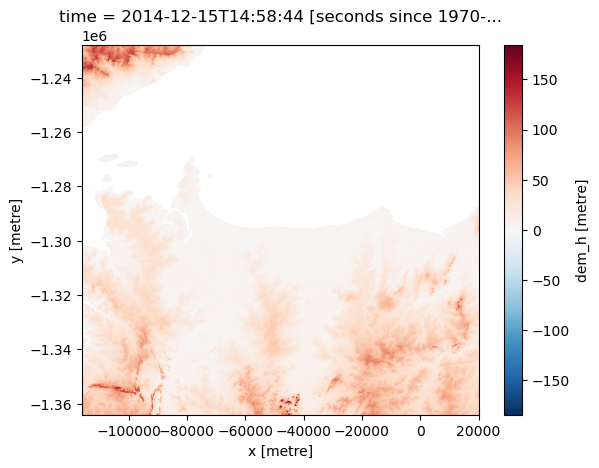

In [47]:
srtm_masked.plot()

In [48]:
# costdist_da_masked = costdist_da.where(srtm_masked)
costdist_da_masked = costdist_da.where(~np.isnan(srtm_masked))

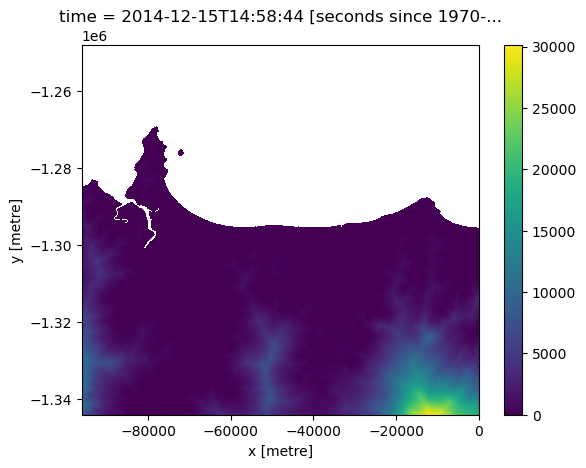

In [49]:
costdist_da_masked.plot()

In [51]:
costdist_da_masked.odc.write_cog("costdist_da_masked.tif", overwrite=True)

PosixPath('costdist_da_masked.tif')

In [26]:
srtm.attrs

{'units': 'metre',
 'nodata': -340282346638528859811704183484516925440,
 'crs': 'EPSG:3577',
 'grid_mapping': 'spatial_ref'}

In [23]:
# cost distance da masked on srtm (to get rid of ocean)

costdist_da_mask = costdist_da.where(srtm)


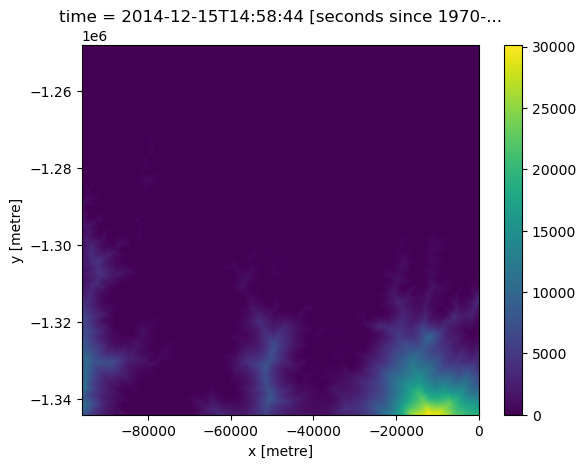

In [24]:
costdist_da_mask.plot()

In [ ]:
srtm_da_test = srtm == ~srtm.nodata


In [ ]:
# Make a copy to avoid modifying the original
srtm_da_oceanmask = srtm_da.copy()

# Set True values to np.nan and False values to True
srtm_da_oceanmask = srtm_da_oceanmask.where(~srtm_da_oceanmask, np.nan).fillna(False)

In [ ]:
srtm_da_oceanmask.plot()

In [ ]:
# costdist_da_threshold = (
#     costdist_da.where(costdist_da != 0, np.nan)
#                .where(costdist_da <= 3500, np.nan)
# )
costdist_da_threshold = (
    costdist_da.where(costdist_da <= 3500, np.nan)
)

In [ ]:
costdist_da_threshold.plot()

In [ ]:
costdist_da_oceanmask = costdist_da_threshold * (~srtm_da)

In [ ]:
costdist_da_oceanmask.plot()

In [ ]:
costdist_da_threshold.odc.write_cog("costdist_da_threshold.tif", overwrite=True)

In [ ]:
# costdist_da.odc.write_cog("costdist_da.tif", overwrite=True)

In [ ]:
# Calculate cost surface (negative values are not allowed, so
# negative nodata values are resolved by clipping values to between
# 0 and infinity)
costs_da = srtm.clip(0, np.inf)

In [ ]:
%%time
# Run cost distance surface
costdist_da = xr_cost_distance(
    cost_da=costs_da,
    starts_da=aquatic,
)

In [ ]:
costdist_da.plot()

In [ ]:
costdist_da_threshold = (
    costdist_da.where(costdist_da != 0, np.nan)
               .where(costdist_da <= 1000, np.nan)
)

In [ ]:
costdist_da_threshold.plot()

In [ ]:
costdist_da_threshold.odc.write_cog("costdist_da_threshold.tif", overwrite=True)

### load HAT and SS

In [ ]:
# load in file
HAT_gpd = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/HAT_file.gpkg') # TODO: Raf, change this back to original file from Paul

# Converting HAT file to CRS 3577 to match gridspec
HAT_gpd_EPSG3577 = HAT_gpd.to_crs("EPSG:3577")

In [ ]:
# load in file
SS_gpd = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/STF_SS_ElevationClasses.geojson')

# Converting SS file to CRS 3577 to match gridspec
SS_gpd_EPSG3577 = SS_gpd.to_crs("EPSG:3577")

In [ ]:
# TODO: Raf, why is this diffferent to previous code?
# example: HAT_SS_gpd = gpd.sjoin(HAT_gpd_EPSG3577, SS_gpd_EPSG3577, predicate='within')
HAT_SS_gpd = gpd.overlay(HAT_gpd_EPSG3577, SS_gpd_EPSG3577, how='intersection')

In [ ]:
# creating a new column in mainland_grid and populating with the sum of HAT and Storm Surge
HAT_SS_gpd['HATSS'] = HAT_SS_gpd['HAT'] + HAT_SS_gpd['SSElev']

### load srtm

In [ ]:
# Load srtm to geobox
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0',like= geobox)
srtm = srtm_ds.dem_h

In [ ]:
# elevation
# greater than -6m AHD and less than 11m AHD == True
# some areas in NT are below 0 AHD and need to be included in potential supratidal extent, hence value of -6 that Raf has checked is sensible.
# 11m max elevation now being used (was 10m previously) due to HAT + SS value max of 10.53m
# for connectivity model less than 11m AHD == True (this needs to be thresholded as minimum at 0 for STF extent product due to supratidal areas not being below 0 AHD
AHD_min = -6
AHD_max = 11
lessthan_AHD = srtm <= AHD_max
greaterthan_AHD = srtm >= AHD_min
srtm_mask = lessthan_AHD & greaterthan_AHD

In [ ]:
srtm_mask = srtm_mask.squeeze('time').astype('int8')

In [ ]:
# get elevation values for srtm_mask
supratidal_elev = srtm * srtm_mask
supratidal_elev = xr.where(supratidal_elev == 0, np.nan, supratidal_elev.values)

### interpolate HAT using srtm bounds

In [ ]:
%%time
# interpolate HAT and SS
interpolate_idw = xr_interpolate(ds=srtm, gdf=HAT_SS_gpd, columns=['HAT', 'SSElev'], method="idw")
HAT_interpolate = interpolate_idw.HAT
SS_interpolate = interpolate_idw.SSElev

# add two layers together
HATSS_interpolate = HAT_interpolate + SS_interpolate

### generate elevation probability product

In [ ]:
# generate elevation probability product
# values of 1 for <= HAT
# values normalised between 1 and 0.5 > HAT and <= HAT_SS
# values normalised between 0.5 and 1 > HAT_SS and <= 10m AHD
HAT = xr.where(supratidal_elev <= HAT_interpolate, 1, np.nan)

In [ ]:
# HAT + storm
HAT_storm = xr.where((supratidal_elev > HAT_interpolate) & (supratidal_elev <= HATSS_interpolate), supratidal_elev.values, np.nan)

# normalise between HAT and HAT_SS
# Find the minimum and maximum values in the data array
min_value = HAT_storm.min()
max_value = HAT_storm.max()
# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_norm = (HAT_storm - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_norm_05_1 = (((1 - HAT_storm_norm)/2) + 0.5)

In [ ]:
# HAT + storm to 11m
HAT_storm_11AHD = xr.where((supratidal_elev > HATSS_interpolate) & (supratidal_elev <= 11), supratidal_elev.values, np.nan)

# normalise between HAT_SS and 11m AHD
# Find the minimum and maximum values in the data array
min_value = HAT_storm_11AHD.min()
max_value = 11
# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_11AHD_norm = (HAT_storm_11AHD - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_11AHD_norm_05_0 = ((1 - HAT_storm_11AHD_norm)/2)

In [ ]:
# combine layers back together
supratidal_combine = ((HAT.fillna(0)) + (HAT_storm_norm_05_1.fillna(0)) + (HAT_storm_11AHD_norm_05_0.fillna(0))).squeeze('time')
# remove outside extent (make np.nan)
supratidal_elevation_model = xr.where(srtm_mask == 1, supratidal_combine.values, np.nan)

In [ ]:
# TODO: Raf, seems there is a problem with some lake areas coming up as values of 1, this was not the case in the previous product. Please rectify
supratidal_elevation_model.plot()